In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TF version:  2.15.0
Eager execution enabled:  False


# ORIGIN EXAMPLE

x_train shape: (60000, 28, 28) y_train shape: (60000,)


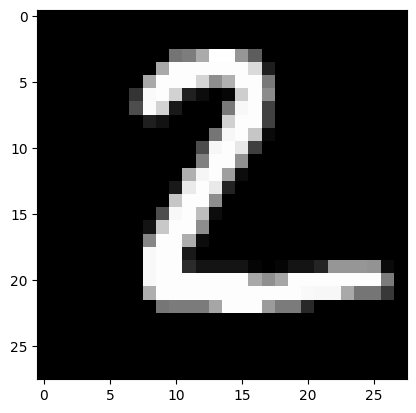

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1]);

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [4]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

In [5]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [6]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=1)
cnn.save('mnist_cnn.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                        

2024-01-19 14:55:07.049674: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-01-19 14:55:07.049694: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-19 14:55:07.049700: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-19 14:55:07.049729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-19 14:55:07.049744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-19 14:55:07.056712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-19 14:55:07.060475: I tensorflow/core/gr

60000/60000 [==============================] - 13s 223us/sample - loss: 0.3344 - acc: 0.8942
Epoch 2/3
60000/60000 [==============================] - 13s 211us/sample - loss: 0.1409 - acc: 0.9592
Epoch 3/3
60000/60000 [==============================] - 14s 225us/sample - loss: 0.1433 - acc: 0.9619


/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

2024-01-19 14:55:46.809433: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_2/bias/Assign' id:674 op device:{requested: '', assigned: ''} def:{{{node dense_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/bias, dense_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-19 14:55:46.927464: W tensorflow/c/c_api.cc:305] Operation '{name:'learning_rate/Assign' id:850 op device:{requested: '', assigned: ''} def:{{{node learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](learning_rate, learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the fu

Test accuracy:  0.9804


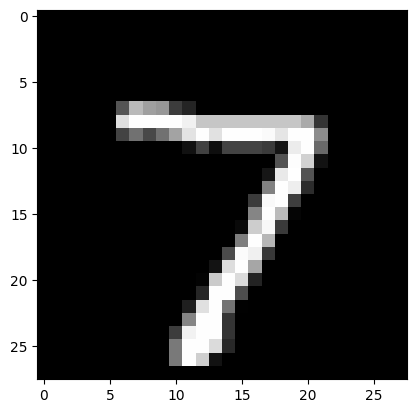

In [8]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28));

In [9]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

In [10]:
cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-19 14:55:49.662162: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1_1/Softmax' id:717 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Explanation took 16.054 sec


Counterfactual prediction: 3 with probability 0.9902468919754028


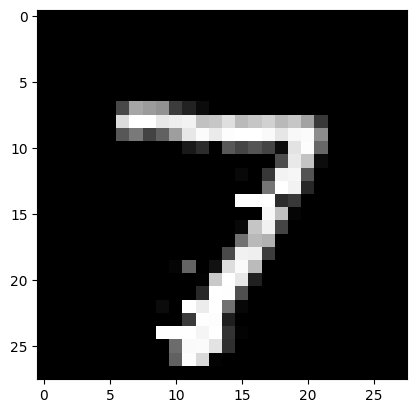

In [11]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

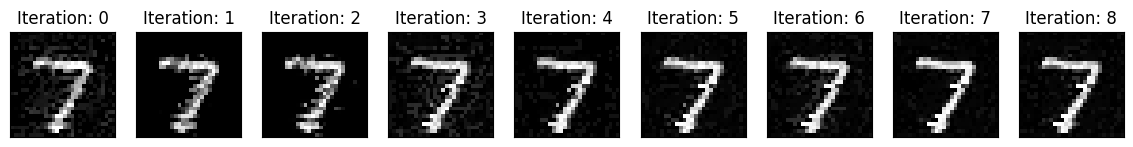

In [12]:
n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(max_lam_steps)])
examples = {}
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                       'X': explanation.all[ix][0]['X']}
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(28,28))
    plt.title(f'Iteration: {key}')

In [21]:
target_class = 2

cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

explanation = start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

2024-01-19 14:57:28.302924: W tensorflow/c/c_api.cc:305] Operation '{name:'cf_search_3/beta2_power/Assign' id:2483 op device:{requested: '', assigned: ''} def:{{{node cf_search_3/beta2_power/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@cf_search/counterfactual"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](cf_search_3/beta2_power, cf_search_3/beta2_power/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Explanation took 14.147 sec


Counterfactual prediction: 2 with probability 0.999722421169281


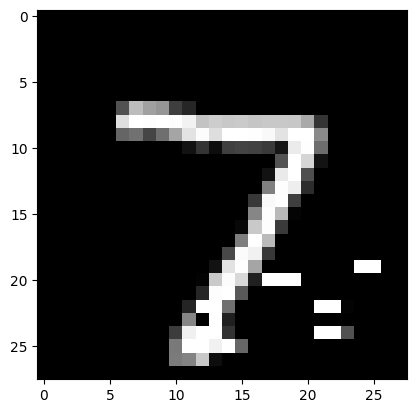

In [22]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

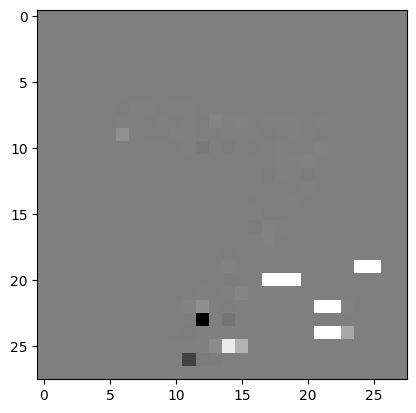

In [23]:
plt.imshow((explanation.cf['X'] - X).reshape(28, 28));

In [ ]:
# os.remove('mnist_cnn.h5')

# OUR DATA

In [2]:
from counterfactuals.datasets import LawDataset

In [3]:
dataset = LawDataset("../data/law.csv")
X_train, X_test, y_train, y_test = dataset.get_split_data()

In [4]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [5]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       111
         1.0       0.76      0.76      0.76       111

    accuracy                           0.76       222
   macro avg       0.76      0.76      0.76       222
weighted avg       0.76      0.76      0.76       222



In [8]:
shape = (1,) + X_train.shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than origin will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (X_train.min(),X_train.max())

In [19]:
Xs_cfs = []
for X, y in zip(dataset.test_dataloader(64, shuffle=False).dataset.tensors[0], dataset.test_dataloader(64, shuffle=False).dataset.tensors[1]):
    X = X.reshape((1,) + X.shape)
    shape = (1,) + X_train.shape[1:]
    cf = Counterfactual(clf, shape=shape, target_proba=target_proba, tol=tol,
                        target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                        max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                        feature_range=feature_range)
    explanation = cf.explain(X)
    Xs_cfs.append(explanation.cf['X'])

tensor([0.6757, 0.3810, 0.6083, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000]) tensor(1.)


In [10]:
cf = Counterfactual(clf.predict_proba, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

2024-01-19 15:37:52.427625: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-01-19 15:37:52.427649: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-19 15:37:52.427656: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-19 15:37:52.427708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-19 15:37:52.427729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Currently only single instance explanations supported (first dim = 1), but first dim = 64


ValueError: can only convert an array of size 1 to a Python scalar

In [11]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
print(f"Original prediction: {clf.predict_proba(X)[0]}")
explanation.cf['X']
# plt.imshow(explanation.cf['X'].reshape(28, 28));

Counterfactual prediction: 0 with probability 0.997248437507424
Original prediction: [0.41630574 0.58369426]


array([[0.03515584, 0.12483323, 0.01623085, 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ]], dtype=float32)

In [14]:
dl = dataset.train_dataloader(64, shuffle=True, noise_lvl=0)

In [19]:
dl.dataset.tensors[0].shape

torch.Size([1994, 12])